### Code for CPU-GPU Benchmarking (Appendix F)

In [1]:
import numpy as np
from timeit import default_timer as timer
from numba import autojit
import matplotlib.pyplot as plt
from scipy import integrate
import time
import pyfftw
%matplotlib inline

# GPU related libraries.
import pyculib.fft
import numba.cuda
from numba import *
from cmath import exp

#### First steps into the GPU Method.

Define the GPU kernel for the Fourier-pseudospectral method.

In [2]:
@numba.cuda.jit
def pseudospectral(guhat,k2,k4,eps,sigma,tpiL,dt):
    xStart, yStart = numba.cuda.grid(2)
    xIntv, yIntv = numba.cuda.gridsize(2)
    for j in range(yStart,guhat.shape[1],yIntv):
        for i in range(xStart,guhat.shape[0],xIntv):
            guhat[i, j] *= exp(0.5*(-1.*eps**2*k4[i,j]*tpiL**4+k2[i,j]*tpiL**2-sigma)*dt)/guhat.shape[0]**2

Define the GPU kernels for the Strong-Stability Preserving 3rd-order Runge-Kutta (SSP-RK3). Here, for each step of the Runge-Kutta time-stepping a new GPU kernel is launched. This can undoubted be improved on. The steps of the SSP-RK3 are respectively

    ssp_rk1,
    ssp_rk2,
    ssp_rk3.
    
`getStencil` is a GPU function that takes the isotropic 4th-order accurate central difference stencil with periodic boundary conditions. Here, the memory accessed is grid-wise and is improperly coalesced for GPU-based calculations. Again, this can undoubted be improved on, e.g. by means of a pencil-stencil mentioned at https://devblogs.nvidia.com/finite-difference-methods-cuda-cc-part-1/.

In [3]:
@numba.cuda.jit(device=True)
def getStencil(x,y,xLim,yLim):
    xLim -= 1
    yLim -= 1
    xp1 = x+1
    xp2 = x+2
    xm1 = x-1
    xm2 = x-2
    yp1 = y+1
    yp2 = y+2
    ym1 = y-1
    ym2 = y-2
    if x == xLim:
        xp1 = 0
        xp2 = 1
    if xp1 == xLim:
        xp2 = 0
    if x == 0:
        xm1 = xLim
        xm2 = xLim-1
    if xm1 == 0:
        xm2 = xLim

    if y == yLim:
        yp1 = 0
        yp2 = 1
    if yp1 == yLim:
        yp2 = 0
    if y == 0:
        ym1 = yLim
        ym2 = yLim-1
    if ym1 == 0:
        ym2 = yLim
        
    return xp1,xp2,xm1,xm2,yp1,yp2,ym1,ym2

@numba.cuda.jit
def ssp_rk1(gv,fu,v1,h,sigma,dt,m):
    coeff = 1./(12.*h**2)
    xLim = gv.shape[0]
    yLim = gv.shape[1]
    xStart, yStart = numba.cuda.grid(2)
    xIntv, yIntv = numba.cuda.gridsize(2)
    for j in range(yStart,yLim,yIntv):
        for i in range(xStart,xLim,xIntv):
            x = j
            y = i
            xp1,xp2,xm1,xm2,yp1,yp2,ym1,ym2 = getStencil(x,y,xLim,yLim)
                
            fu[x,y] = coeff * (-60.*gv[x,y].real**3 - 1.*(gv[xm2,y].real**3 + gv[x,ym2].real**3 + gv[xp2,y].real**3 + gv[x,yp2].real**3) \
                           + 16. * (gv[xm1,y].real**3 + gv[x,ym1].real**3 + gv[xp1,y].real**3 + gv[x,yp1].real**3))
            
            v1[x,y] = gv[x,y].real + dt * (fu[x,y] + sigma*m)

@numba.cuda.jit
def ssp_rk2(gv,fu,v1,v2,h,sigma,dt,m):
    coeff = 1./(12.*h**2)
    xLim = gv.shape[0]
    yLim = gv.shape[1]
    xStart, yStart = numba.cuda.grid(2)
    xIntv, yIntv = numba.cuda.gridsize(2)
    for j in range(yStart,yLim,yIntv):
        for i in range(xStart,xLim,xIntv):
            x = j
            y = i
            xp1,xp2,xm1,xm2,yp1,yp2,ym1,ym2 = getStencil(x,y,xLim,yLim)
                
            fu[x,y] = coeff * (-60.*v1[x,y].real**3 - 1.*(v1[xm2,y].real**3 + v1[x,ym2].real**3 + v1[xp2,y].real**3 + v1[x,yp2].real**3) \
                           + 16. * (v1[xm1,y].real**3 + v1[x,ym1].real**3 + v1[xp1,y].real**3 + v1[x,yp1].real**3))
            
            v2[x,y] = 3./4 * gv[x,y].real + 1./4 * v1[x,y].real + 1./4 * dt * (fu[x,y] + sigma*m)
                
@numba.cuda.jit
def ssp_rk3(gv,fu,v2,v3,h,sigma,dt,m):
    coeff = 1./(12.*h**2)
    xLim = gv.shape[0]
    yLim = gv.shape[1]
    xStart, yStart = numba.cuda.grid(2)
    xIntv, yIntv = numba.cuda.gridsize(2)
    for j in range(yStart,yLim,yIntv):
        for i in range(xStart,xLim,xIntv):
            x = j
            y = i
            xp1,xp2,xm1,xm2,yp1,yp2,ym1,ym2 = getStencil(x,y,xLim,yLim)
            
            fu[x,y] = coeff * (-60.*v2[x,y].real**3 - 1.*(v2[xm2,y].real**3 + v2[x,ym2].real**3 + v2[xp2,y].real**3 + v2[x,yp2].real**3) \
                           + 16. * (v2[xm1,y].real**3 + v2[x,ym1].real**3 + v2[xp1,y].real**3 + v2[x,yp1].real**3))
            
            v3[x,y] = 1./3 * gv[x,y].real + 2./3 * v2[x,y].real + 2./3 * dt * (fu[x,y] + sigma*m)

The main DFT looping by means of the GPU.

In [4]:
# define system parameters.
m = 0.33
C = 0.01
L = 6.
Nx = 64
h = L/Nx
C0 = 0.0015 / (L/64)**2

# initial conditions used for determining the error of convergence.
pts = np.linspace(0.,L,Nx)
xx, yy = np.meshgrid(pts,pts)
u = np.empty((Nx,Nx), dtype='complex128')
u[:,:] = m + C*np.sin(np.pi*xx)*np.sin(np.pi*yy)

# random initial conditions.
# seed = 693
# np.random.seed(seed)
# u[:,:] = m + C*np.random.uniform(-1.,1.,(Nx,Nx))

# get wavenumber / frequency grid.
freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
kx, ky = np.meshgrid(freqs,freqs)
k = kx + ky
k2 = kx**2+ky**2
k4 = k2**2

# define yet more system parameters.
tpiL = 2*np.pi/L
delta = 0.50
eps = 0.1
sigma = 0.50
dt = 0.001
dt = C0*h**2
#dt = 5e-6 # used for the 'exact solution'.

# pre-allocate device (GPU) and host (CPU) arrays. 
uhat = np.empty_like(u, dtype='complex128')
v = np.empty_like(u, dtype='complex128')

gu = numba.cuda.to_device(u)
guhat = numba.cuda.device_array((Nx,Nx),dtype='complex128')
guhat_1 = numba.cuda.device_array((Nx,Nx),dtype='complex128')
gv = numba.cuda.device_array((Nx,Nx),dtype='complex128')
v3 = numba.cuda.device_array((Nx,Nx),dtype='complex128')

v1 = numba.cuda.device_array((Nx,Nx),dtype='float64')
v2 = numba.cuda.device_array((Nx,Nx),dtype='float64')
fu = numba.cuda.device_array((Nx,Nx),dtype='float64')

# define cuFFT plans.
FFTplan = pyculib.fft.FFTPlan(shape=(Nx,Nx), itype='complex128', otype='complex128')
FFTplan_1 = pyculib.fft.FFTPlan(shape=(Nx,Nx), itype='complex128', otype='complex128')

it = int(1./dt)+1
print(it)

# define blocks per grid and threads per block to use.
blocks = 64
threads = 16

bpg = (blocks, blocks)
tpb = (threads, threads)

t2 = 0.
t3 = 0.

tic1 = time.time()
for i in range(it):
    # the first substep of the Strang-splitting (equivalent to eqn 4.5a): Fourier-PS
    tic2 = time.time()
    FFTplan.forward(gu, guhat)
    pseudospectral[bpg,tpb](guhat,k2,k4,eps,sigma,tpiL,dt)
    FFTplan.inverse(guhat, gv)
    numba.cuda.synchronize()
    toc2 = time.time()
    t2 += toc2-tic2
    
    # the second substep of the Strang-splitting (equivalent to eqn 4.5b): SSP-RK3
    tic3 = time.time()
    ssp_rk1[bpg,tpb](gv,fu,v1,h,sigma,dt,m)
    numba.cuda.synchronize()
    ssp_rk2[bpg,tpb](gv,fu,v1,v2,h,sigma,dt,m)
    numba.cuda.synchronize()
    ssp_rk3[bpg,tpb](gv,fu,v2,v3,h,sigma,dt,m)
    numba.cuda.synchronize()
    toc3 = time.time()
    t3 += toc3-tic3
    
    # the third substep of the Strang-splitting (equivalent to eqn 4.5c): Fourier-PS
    FFTplan.forward(v3, guhat)
    pseudospectral[bpg,tpb](guhat,k2,k4,eps,sigma,tpiL,dt)
    FFTplan.inverse(guhat, gu)
    numba.cuda.synchronize()

toc1 = time.time()
t1 = toc1-tic1

print("time taken t1: %.2f" %(t1))
print("time taken t2: %.2f" %(t2))
print("time taken t3: %.2f" %(t3))

667
time taken t1: 16.91
time taken t2: 9.12
time taken t3: 5.81


Plot the result of the DFT simulation above.

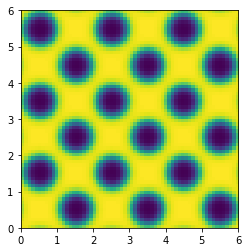

In [6]:
# transfer result array from GPU to CPU.
gu.to_host()

np.savetxt('uArray-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s.txt' %(dt,it,Nx,sigma,m), u.real)
plt.imshow(u.real,origin='left', extent=[0,L,0,L])
plt.show()

#### CPU Method.
The cells/codes below are the same as in 2D_Strang_SSP_RK3.ipynb. The Jupyter Notebook makes importing the corresponding code a little complex, so I simply copied and pasted it here. I am aware that there are better or more elegant ways to overcome this. But this is the simplest that works.

For comments or more details on the methods, please refer to *2D_Strang_SSP_RK3.ipynb*.

In [34]:
@autojit
def shift1(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return E + F + G + H

@autojit
def centralDiffShift1(A,h,Nx):
    A = A**3
    D = np.empty_like((Nx,Nx))
    D = -1.*shift1(A,2)+ 16.*shift1(A,1) - 60.*A
    return D/(12.*h**2)

In [35]:
wisdom = None

In [ ]:
L = 6.
#L = 5.0

Nx = 32
C0 = 0.0015/(L/64)**2
h = L/Nx

dx = np.linspace(0,L,Nx)
dt = C0*h**2
#dt = 5e-6
#dt = 0.001
eps = 0.1
sigma = 0.50

m = 0.33

it = int(1./dt)
#it = 5000
it = 50
it += 1
lv = int(it/5)

seed = 693
np.random.seed(seed)
r = np.random.uniform(-1.,1.,(Nx,Nx))

if r.mean()<0:
    r -= r.mean()
else:
    r += r.mean()

# a scaling factor
C = 0.01

tpiL = 2.*np.pi/L

u = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
vp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
vpp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)

pts = np.linspace(0,L,Nx)
xx, yy = np.meshgrid(pts,pts)
#u[:,:] = m + C*r
u[:,:] = m + C*np.sin(np.pi*xx)*np.sin(np.pi*yy)

fft_object = pyfftw.FFTW(u, vpp, threads=4, axes=(0,1))
ifft_object = pyfftw.FFTW(vpp, v, direction='FFTW_BACKWARD', threads=4, axes=(0,1))
    
fft_object = pyfftw.FFTW(v, vp, threads=4, axes=(0,1))
ifft_object = pyfftw.FFTW(vp, u, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
kx, ky = np.meshgrid(freqs,freqs)
k = kx + ky
k2 = kx**2+ky**2
k4 = k2**2

avgConc = np.zeros(it/lv+1)
energy = np.zeros(it/lv+1)

if wisdom != None:
    pyfftw.import_wisdom(wisdom)

j = 0
t1 = 0
t2 = 0
t3 = 0

print(it)
    
for i in xrange(it+1):
    tic1 = time.time()
    vpp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(u)
    v = ifft_object(vpp).real
    toc1 = time.time()
    t1 += (toc1-tic1)
    
    tic2 = time.time()
    v1 = v.real + dt * (centralDiffShift1(v.real,h,Nx) + sigma*m)
    v2 = 3./4. * v + 1./4. * v1 + 1./4. * dt * (centralDiffShift1(v1,h,Nx) + sigma*m)
    v = 1./3. * v + 2./3. * v2 + 2./3. * dt *  (centralDiffShift1(v2,h,Nx) + sigma*m)
    toc2 = time.time()
    t2 += (toc2-tic2)
    
    tic3 = time.time()
    vp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(v)
    u = ifft_object(vp).real
    toc3 = time.time()
    t3 += (toc3-tic3)
    
    if i%int((it-1)/10)==0:
        fig1 = plt.figure(figsize=(3,3))
        plt.imshow(u.real,origin='left', extent=[0,L,0,L])
        
    if i%lv==0:
        dim = 2
        u0 = u
        for d in range(dim):
            u0 = integrate.trapz(u0,dx)
        avgConc[j] = u0 / L**2
        
        T1 = -1.j * k * tpiL * np.fft.fft2(u)
        T1 = np.real(np.fft.ifft2(T1))
        T1 = 0.5*eps**2*abs(T1)**2

        T2 = 1./4*(np.real(u)**2-1.)**2

        up = np.real(u)-m
        for d in range(dim):
            up = integrate.trapz(up,dx)
        T3 = -1.*up
        T3 = 0.5*sigma*abs(T3)**2

        en = T1 + T2 + T3
        en = np.real(en)
        for d in range(dim):
            en = integrate.trapz(en,dx)
        energy[j] = en
        j += 1

wisdom = pyfftw.export_wisdom()

energy /= energy[0]

print("time taken1: %.2f" %(t1))
print("time taken2: %.2f" %(t2))
print("time taken3: %.2f" %(t3))
print("total time taken: %.2f" %(t1+t2+t3))

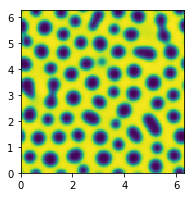

In [132]:
fig = plt.figure(figsize=(3,3))
plt.imshow(u,origin='left', extent=[0,L,0,L])

#### Benchmarking codes.

#### Fourier-PS

Below is the time-measurement for only the Fourier-PS substep for the GPU (CUDA) method. As the GPU kernels cannot be launched as part of a function, I recorded the time-taken manually in a separate array.

In [ ]:
C = 0.01
m = 0.33
Nx = 2048
it = 50
eps = 0.1
sigma = 0.5
L = 5.0
tpiL = 2.*np.pi/L
dt = 0.001

seed = 3175
np.random.seed(seed)

freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
kx, ky = np.meshgrid(freqs,freqs)
k = kx + ky
k2 = kx**2+ky**2
k4 = k2**2

u = np.empty((Nx,Nx), dtype='complex128')
u[:,:] = m + C*np.random.uniform(-1.,1.,(Nx,Nx))

t2 = 0

gu = numba.cuda.to_device(u)
guhat = numba.cuda.device_array((Nx,Nx),dtype='complex128')
guhat_1 = numba.cuda.device_array((Nx,Nx),dtype='complex128')
gv = numba.cuda.device_array((Nx,Nx),dtype='complex128')

FFTplan = pyculib.fft.FFTPlan(shape=(Nx,Nx), itype='complex128', otype='complex128')

blocks = 64
threads = 16

bpg = (blocks, blocks)
tpb = (threads, threads)

for i in range(it):
    tic2 = time.time()
    FFTplan.forward(gu, guhat)
    pseudospectral[bpg,tpb](guhat,k2,k4,eps,sigma,tpiL,dt)
    FFTplan.inverse(guhat, gv)
    numba.cuda.synchronize()
    toc2 = time.time()
    t2 += toc2-tic2

print(t2)

Then, functions for the Fourier-PS substep using other CPU-based methods are below.

1. `npfft_test` is a function measuring the time taken for the numpy fft method.
2. `pyfftw_test` is for the pyFFTW with no parallelisation.
3. `pyfftw_test_parallel` is for the pyFFTW with 4 parallel threads on the CPU.

In [89]:
def npfft_test(u0,eps,sigma,k2,k4,tpiL,dt,it):
    t0 = 0
    for  i in range(it):
        tic0 = time.time()
        uhat = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*np.fft.fft2(u0).real
        u1 = np.fft.ifft2(uhat).real
        toc0 = time.time()
        t0 += toc0-tic0
    return t0

def pyfftw_test(u1,eps,sigma,k2,k4,tpiL,dt,it):
    t1 = 0
    v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    vpp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    
    fft_object = pyfftw.FFTW(u, vpp, threads=1, axes=(0,1))
    ifft_object = pyfftw.FFTW(vpp, v, direction='FFTW_BACKWARD', threads=1, axes=(0,1))
    
    for  i in range(it):
        tic1 = time.time()
        vpp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(u1)
        v = ifft_object(vpp).real
        toc1 = time.time()
        t1 += (toc1-tic1)
    return t1

def pyfftw_test_parallel(u1,eps,sigma,k2,k4,tpiL,dt,it):
    t1 = 0
    v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    vpp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
    
    fft_object = pyfftw.FFTW(u, vpp, threads=4, axes=(0,1))
    ifft_object = pyfftw.FFTW(vpp, v, direction='FFTW_BACKWARD', threads=4, axes=(0,1))
    
    for  i in range(it):
        tic1 = time.time()
        vpp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(u1)
        v = ifft_object(vpp).real
        toc1 = time.time()
        t1 += (toc1-tic1)
    return t1

The above functions make time-measurements easier. The time-taken are recorded in the respective arrays.

In [95]:
it = 50

Nxs = [64,128,256,512,1024,2048]
t0s = np.zeros((len(Nxs)))
t1s = np.zeros((len(Nxs)))
t1as = np.zeros((len(Nxs)))

u1 = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)

j = 0
for Nx in Nxs:
    u = np.empty((Nx,Nx), dtype='complex128')
    u[:,:] = m + C*np.random.uniform(-1.,1.,(Nx,Nx))
    u0 = np.copy(u)
    u1 = np.copy(u)
    
    freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
    kx, ky = np.meshgrid(freqs,freqs)
    k = kx + ky
    k2 = kx**2+ky**2
    k4 = k2**2

    t0s[j] = npfft_test(u0,eps,sigma,k2,k4,tpiL,dt,it)
    t1s[j] = pyfftw_test(u1,eps,sigma,k2,k4,tpiL,dt,it)
    t1as[j] = pyfftw_test_parallel(u1,eps,sigma,k2,k4,tpiL,dt,it)
    j += 1

Time measured for *cuFFT* in seconds. As mentioned, since the GPU kernels cannot be run as part of a function, I store the time measured manually in this array.

In [97]:
t2s = [0.141999959946, 0.205000162125, 0.421000003815, 1.21799993515, 3.93400001526, 15.0580000877]
t2s = np.array(t2s)

The time taken for the other methods.

    t0s = numpy fft
    t1s = pyFFTW (1 thread)
    t2s = pyFFTW (4 threads)

In [96]:
print(t0s)
print(t1s)
print(t1as)

[  5.79998493e-02   9.39998627e-02   6.32999897e-01   3.35200000e+00
   1.40960000e+01   6.19399998e+01]
[  1.10001564e-02   3.70001793e-02   3.01000118e-01   1.68600011e+00
   7.21000004e+00   3.20699997e+01]
[  1.30000114e-02   3.60000134e-02   3.05000067e-01   1.50599980e+00
   8.21700001e+00   2.83920000e+01]


Plot the benchmarking result for the Fourier-PS substep.

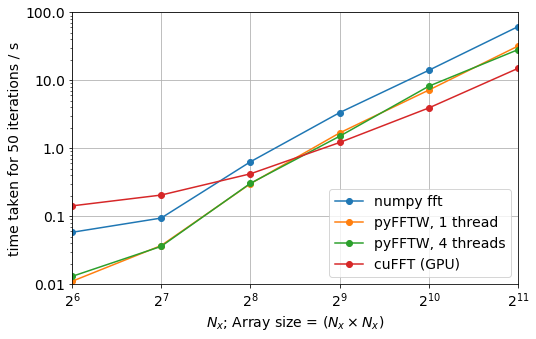

In [157]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
fig3 = plt.figure(figsize = (8,5))
plt.semilogy(np.log2(Nxs),t0s,'-o', label='numpy fft')
plt.semilogy(np.log2(Nxs),t1s,'-o', label='pyFFTW, 1 thread')
plt.semilogy(np.log2(Nxs),t1as,'-o', label='pyFFTW, 4 threads')
plt.semilogy(np.log2(Nxs),t2s,'-o', label='cuFFT (GPU)')

plt.legend(loc = 'lower right')
plt.grid()

plt.ylabel(r'time taken for 50 iterations / s')

plt.xticks([6,7,8,9,10,11],[r'$2^6$',r'$2^7$',r'$2^8$',r'$2^9$',r'$2^{10}$',r'$2^{11}$'])
plt.yticks([0.01,0.1,1.0,10.0,100.0],[0.01,0.1,1.0,10.0,100.0])
plt.xlabel(r'$N_x$; Array size = $(N_x \times N_x)$')
plt.xlim(6,11)
plt.ylim(0.01,100)
plt.savefig('ec_ps.pdf', bbox_inches='tight')
plt.show()

#### SSP-RK3 + Central Difference

The time-measurement for the GPU-based SSP-RK3 + 4th order accurate central difference.

In [178]:
blocks = 64
threads = 16
Nx = 2048
it = 50

u = np.empty((Nx,Nx), dtype='complex128')
u[:,:] = m + C*np.random.uniform(-1.,1.,(Nx,Nx))

bpg = (blocks, blocks)
tpb = (threads, threads)

gv = numba.cuda.to_device(u)
v3 = numba.cuda.device_array((Nx,Nx),dtype='complex128')

v1 = numba.cuda.device_array((Nx,Nx),dtype='float64')
v2 = numba.cuda.device_array((Nx,Nx),dtype='float64')
fu = numba.cuda.device_array((Nx,Nx),dtype='float64')

t3 = 0
for i in range(it):
    tic3 = time.time()
    ssp_rk1[bpg,tpb](gv,fu,v1,h,sigma,dt,m)
    numba.cuda.synchronize()
    ssp_rk2[bpg,tpb](gv,fu,v1,v2,h,sigma,dt,m)
    numba.cuda.synchronize()
    ssp_rk3[bpg,tpb](gv,fu,v2,v3,h,sigma,dt,m)
    numba.cuda.synchronize()
    toc3 = time.time()
    t3 += toc3-tic3

Functions to measure time-taken for the other CPU-based methods for the SSP-RK3 + 4th order accurate Central Difference.

In [263]:
#@numba.autojit
def getStencil(x,y,xLim,yLim):
    xLim -= 1
    yLim -= 1
    xp1 = x+1
    xp2 = x+2
    xm1 = x-1
    xm2 = x-2
    yp1 = y+1
    yp2 = y+2
    ym1 = y-1
    ym2 = y-2
    if x == xLim:
        xp1 = 0
        xp2 = 1
    if xp1 == xLim:
        xp2 = 0
    if x == 0:
        xm1 = xLim
        xm2 = xLim-1
    if xm1 == 0:
        xm2 = xLim

    if y == yLim:
        yp1 = 0
        yp2 = 1
    if yp1 == yLim:
        yp2 = 0
    if y == 0:
        ym1 = yLim
        ym2 = yLim-1
    if ym1 == 0:
        ym2 = yLim
        
    return xp1,xp2,xm1,xm2,yp1,yp2,ym1,ym2

#@numba.autojit
def for_loops(u,h,it):
    xLim = u.shape[0]
    yLim = u.shape[1]
    u = u**3
    nlU = np.zeros((xLim,yLim))
    for x in range(xLim):
        for y in range(yLim):
            xp1,xp2,xm1,xm2,yp1,yp2,ym1,ym2 = getStencil(x,y,xLim,yLim)
            nlU[y,x] = (-1.*u[y,xm2] + 16.*u[y,xm1] - 30.*u[y,x] + 16.*u[y,xp1] - 1.*u[y,xp2]) / (12.*h**2) + \
                        (-1.*u[ym2,x] + 16.*u[ym1,x] - 30.*u[y,x] + 16.*u[yp1,x] - 1.*u[yp2,x]) / (12.*h**2)
    return nlU

@numba.autojit
def nproll(u,h,it):
    u = u**3
    u = (-1.*(np.roll(u,-2,axis=0)+np.roll(u,-2,axis=1)+np.roll(u,2,axis=0)+np.roll(u,2,axis=1)) + \
            16*(np.roll(u,-1,axis=0)+np.roll(u,-1,axis=1)+np.roll(u,1,axis=0)+np.roll(u,1,axis=1)) - \
            60*u) / (12.*h**2)
    return u
    
@numba.autojit
def shift1(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return E + F + G + H

@numba.autojit
def centralDiffShift1(u,h,it):
    D = np.empty_like(u)
    u = u**3
    D = (-1.*shift1(u,2)+ 16.*shift1(u,1) - 60.*u) /(12.*h**2)
    return D

Time measured in seconds for different methods. The CUDA array is stored as before, as the GPU kernels cannot be launched in functions, I had to store the time taken manually.

The other arrays store the time values of the methods with **no** Numba just-in-time (JIT) compilation. Since the JIT calls are interpreter directives, I decided to just comment them out for (no jit) methods, and store the time values here.

In [274]:
# CUDA.
t3s = [0.275000095367,0.325000047684,0.455000162125,0.835000038147,2.18700003624,6.07400012016]

# For-loops (no jit)
t0as = [4.0769999,20.80199981,66.95099998,270.97000003,753.01203801]

# np.roll
t1as = [1.09999895e-01,4.51999903e-01,2.03299999e+00,1.07590001e+01,4.51719999e+01,1.81705000e+02]

# shift algorithm (no jit)
t2as = [6.90000057e-02,4.21999931e-01,1.74799991e+00,1.05179999e+01,4.27219999e+01,1.81942000e+02]

I wrote a separate test for the simple for-looping (no JIT, no optimisations), as the time taken is **much** longer compared to the other methods. Below is the test.

In [266]:
Nxs = [512]
t0bs = np.zeros((len(Nxs)))

j = 0
t0b = 0 
for Nx in Nxs:
    h = L/Nx

    u = np.empty((Nx,Nx), dtype='float64')
    u[:,:] = m + C*np.random.uniform(-1.,1.,(Nx,Nx))
    
    u0 = np.copy(u)
    
    if (Nx<= 5000):
        tic0b = time.time()
        for i in range(it):
            v1 = u0 + dt * (for_loops(u0,h,Nx) + sigma*m)
            v2 = 3./4. * u0 + 1./4. * v1 + 1./4. * dt * (for_loops(v1,h,Nx) + sigma*m)
            v = 1./3. * u0 + 2./3. * v2 + 2./3. * dt *  (for_loops(v2,h,Nx) + sigma*m)
        toc0b = time.time()
        t0b += (toc0b-tic0b)
        t0bs[j] = t0b

The other CPU-based methods for the SSP-RK3 + central difference are tested together here, and the time taken are stored in the respective arrays. The corresponding arrays names are:

    t0as = for-looping (no JIT)
    t0s = for-looping (JIT)
    t1s = numpy roll
    t2as = shift algorithm (no JIT)
    t2s = shift algorithm (JIT)
    t3s = CUDA (GPU)

In [257]:
Nxs = [64,128,256,512,1024,2048]
t0s = np.zeros((len(Nxs)))
t1s = np.zeros((len(Nxs)))
t2s = np.zeros((len(Nxs)))

j = 0
t0 = 0 
t1 = 0
t2 = 0
for Nx in Nxs:
    h = L/Nx

    u = np.empty((Nx,Nx), dtype='float64')
    u[:,:] = m + C*np.random.uniform(-1.,1.,(Nx,Nx))
    
    u0 = np.copy(u)
    u1 = np.copy(u)
    u2 = np.copy(u)
    
    if (Nx<= 5000):
        tic0 = time.time()
        for i in range(it):
            v1 = u0 + dt * (for_loops(u0,h,Nx) + sigma*m)
            v2 = 3./4. * u0 + 1./4. * v1 + 1./4. * dt * (for_loops(v1,h,Nx) + sigma*m)
            v = 1./3. * u0 + 2./3. * v2 + 2./3. * dt *  (for_loops(v2,h,Nx) + sigma*m)
        toc0 = time.time()
        t0 += (toc0-tic0)
        t0s[j] = t0
    
    tic1 = time.time()
    for i in range(it):
        v1 = u1 + dt * (nproll(u1.real,h,Nx) + sigma*m)
        v2 = 3./4. * u1 + 1./4. * v1 + 1./4. * dt * (nproll(v1,h,Nx) + sigma*m)
        v = 1./3. * u1 + 2./3. * v2 + 2./3. * dt *  (nproll(v2,h,Nx) + sigma*m)
    toc1 = time.time()
    t1 += (toc1-tic1)
    t1s[j] = t1
    
    tic2 = time.time()
    for i in range(it):
        v1 = u2 + dt * (centralDiffShift1(u2.real,h,Nx) + sigma*m)
        v2 = 3./4. * u2 + 1./4. * v1 + 1./4. * dt * (centralDiffShift1(v1,h,Nx) + sigma*m)
        v = 1./3. * u2 + 2./3. * v2 + 2./3. * dt *  (centralDiffShift1(v2,h,Nx) + sigma*m)
    toc2 = time.time()
    t2 += (toc2-tic2)
    t2s[j] = t2
    
    j += 1

Plot the benchmarking result for the SSP-RK3 + central difference substep.

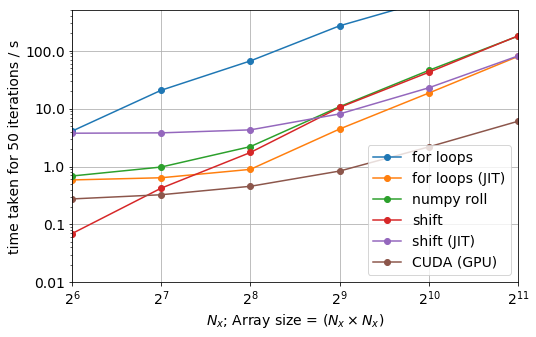

In [277]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

Nxs = [64,128,256,512,1024,2048]

fig3 = plt.figure(figsize = (8,5))
plt.semilogy(np.log2(Nxs[:-1]),t0as,'-o', label='for loops')
plt.semilogy(np.log2(Nxs),t0s,'-o', label='for loops (JIT)')
plt.semilogy(np.log2(Nxs),t1s,'-o', label='numpy roll')
plt.semilogy(np.log2(Nxs),t2as,'-o', label='shift')
plt.semilogy(np.log2(Nxs),t2s,'-o', label='shift (JIT)')
plt.semilogy(np.log2(Nxs),t3s,'-o', label='CUDA (GPU)')

plt.legend(loc = 'lower right')
plt.grid()

plt.ylabel(r'time taken for 50 iterations / s')
plt.xticks([6,7,8,9,10,11],[r'$2^6$',r'$2^7$',r'$2^8$',r'$2^9$',r'$2^{10}$',r'$2^{11}$'])
plt.yticks([0.01,0.1,1.0,10.0,100.0],[0.01,0.1,1.0,10.0,100.0])
plt.xlabel(r'$N_x$; Array size = $(N_x \times N_x)$')
plt.xlim(6,11)
plt.ylim(0.01,500)
plt.savefig('ec_ssprk3_cd.pdf', bbox_inches='tight')
plt.show()